In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import lightgbm as lgbm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time

from tqdm import tqdm
from multiprocessing import Pool
from itertools import repeat
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

from utils import load_json
from features import calc_feats_single_ticker
from data import load_quarterly_data_fmpapi, load_cf1_df
from models import QuarterlyOOFModel
sns.set()

config = load_json("config.json")


In [55]:
tickers_df.columns

Index(['table', 'permaticker', 'ticker', 'name', 'exchange', 'isdelisted',
       'category', 'cusips', 'siccode', 'sicsector', 'sicindustry',
       'famasector', 'famaindustry', 'sector', 'industry', 'scalemarketcap',
       'scalerevenue', 'relatedtickers', 'currency', 'location', 'lastupdated',
       'firstadded', 'firstpricedate', 'lastpricedate', 'firstquarter',
       'lastquarter', 'secfilings', 'companysite'],
      dtype='object')

In [2]:
tickers_df = pd.read_csv('{}/cf1/tickers.csv'.format(config['data_path']))
tickers_df = tickers_df[tickers_df['currency']=='USD']
ticker_list = tickers_df['ticker'].unique().tolist()

In [4]:
arr = []
for ticker in tqdm(ticker_list[:500]):
    path = '{}/cf1/core_fundamental/{}.json'.format(config['data_path'], ticker)
    if os.path.exists(path):
        curr_df = load_cf1_df(path)
        arr.append(curr_df)
        
df = pd.concat(arr, axis=0)
df = df.infer_objects()
df = df[df['dimension']=='ARQ']
df = df[df['marketcap'].isnull()==False]
df = df.sort_values('marketcap', ascending=False)#[['ticker', 'marketcap']]

100%|██████████| 500/500 [00:03<00:00, 144.03it/s]


In [52]:
df.shape

(89428, 2)

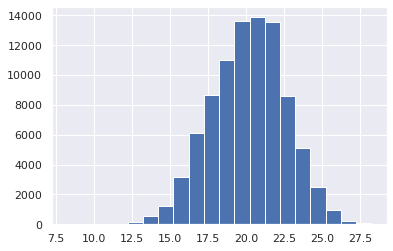

In [152]:
plt.hist(np.log(df['marketcap'].values), bins=20)
plt.show()

In [6]:
columns = df.columns[df.dtypes == 'float64']

In [183]:
# load_quarterly_data_fmpapi('AAPL', config)
# load_quarterly_data_cf1('AAPL', 'ARQ', config)

In [7]:
columns

Index(['accoci', 'assets', 'assetsavg', 'assetsc', 'assetsnc', 'assetturnover',
       'bvps', 'capex', 'cashneq', 'cashnequsd',
       ...
       'sharesbas', 'shareswa', 'shareswadil', 'sps', 'tangibles', 'taxassets',
       'taxexp', 'taxliabilities', 'tbvps', 'workingcapital'],
      dtype='object', length=105)

In [163]:
columns = ['revenue', 'netinc', 'ncf', 'assets', 'ebitda', 'debt', 'fcf', 'gp', 'workingcapital',
          'cashneq', 'rnd', 'sgna']
#columns = ['revenue', 'netinc', 'fcf', 'gp', ]


In [164]:
p = Pool(10)
#columns = ['revenue', 'netinc']
params_gen = zip(ticker_list, repeat(10), repeat(columns))
X = []
for ticker_feats_arr in tqdm(p.starmap(calc_feats_single_ticker, params_gen)):
    X.extend(ticker_feats_arr)
    
X = pd.DataFrame(X)
X = X[X['marketcap'].isnull()==False]


100%|██████████| 14513/14513 [00:00<00:00, 1618762.20it/s]


In [165]:
X = pd.merge(X, tickers_df[['ticker', 'sector']], on='ticker', how='left')
le = LabelEncoder()
X['sector'] = le.fit_transform(X['sector'].fillna('None'))
X = X[X['marketcap'] > 1e9]
X.index = range(len(X))

In [166]:
#model = QuarterlyOOFModel(lgbm.sklearn.LGBMRegressor(learning_rate=0.001, n_estimators=2000))
model = QuarterlyOOFModel(lgbm.sklearn.LGBMRegressor())
#model = QuarterlyOOFModel(LinearRegression())

In [167]:
model.fit(X.drop(['ticker', 'marketcap', 'date'], axis=1),
          X['marketcap'], X['ticker'])

0
1
2
3
4


In [168]:
pred = model.predict(X.drop(['ticker', 'marketcap', 'date'], axis=1), X['ticker'])

0
1
2
3
4


In [169]:
pred_df = pd.DataFrame()
pred_df['ticker'] = X['ticker']
pred_df['date'] = X['date'].apply(lambda x: np.datetime64(x))
pred_df['marketcap'] = X['marketcap']
pred_df['pred_marketcap'] = pred

In [170]:
pred_df = pd.merge(pred_df, tickers_df[['ticker', 'sector']], on='ticker', how='left')

In [89]:
pred_df[pred_df['ticker']=='AAPL']

,ticker,date,marketcap,pred_marketcap,sector
17628,AAPL,2020-10-30,1.850816e+12,1.288987e+12,Technology
17629,AAPL,2020-07-31,1.817315e+12,1.128847e+12,Technology
17630,AAPL,2020-05-01,1.252926e+12,1.280558e+12,Technology
17631,AAPL,2020-01-29,1.419143e+12,1.275333e+12,Technology
17632,AAPL,2019-10-31,1.105307e+12,1.292642e+12,Technology
17633,AAPL,2019-07-31,9.627661e+11,9.797526e+11,Technology
17634,AAPL,2019-05-01,9.686183e+11,1.284532e+12,Technology
17635,AAPL,2019-01-30,7.792000e+11,1.303940e+12,Technology
17636,AAPL,2018-11-05,9.566248e+11,1.141712e+12,Technology
17637,AAPL,2018-08-01,9.732301e+11,1.158080e+12,Technology


In [90]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(pred_df['marketcap'], pred_df['pred_marketcap']))

26917292231.60236

In [171]:
(np.abs(pred_df['marketcap'] - pred_df['pred_marketcap']) / pred_df['marketcap']).mean()

0.6205665382679323

In [ ]:
0.6205665382679323
0.6310080731364811
0.653126074942933
0.6600834000734956
0.6860760141205562
0.784335341238446
0.0827242968444192 leak

In [ ]:
17028167802.33793

In [ ]:
22880198378.22676
26917292231.60236
28808703606.695988


In [ ]:
17600633470.14652
20815281134.949924
24405532842.28744

In [ ]:
15078804193.209795
26568216766.17286 revenue_usd
27097687112.421253
29627158860.85553
29732987604.258324
39131318516.46186

In [137]:
imp_df = pd.DataFrame()
imp_df['column'] = X.drop(['ticker', 'marketcap', 'date'], axis=1).columns
imp_df['importance'] = model.base_models[0].feature_importances_
imp_df.sort_values('importance', ascending=False)[:30]

,column,importance
92,quarter10_netinc_mean,75
129,quarter10_rnd_max,71
131,quarter10_rnd_std,67
121,quarter10_workingcapital_max,66
112,quarter10_fcf_mean,63
84,quarter4_rnd_mean,62
108,quarter10_debt_mean,61
41,quarter2_rnd_max,58
132,sector,57
95,quarter10_netinc_std,56


In [16]:
imp_df = pd.DataFrame()
imp_df['column'] = X.drop(['ticker', 'marketcap', 'date'], axis=1).columns
imp_df['importance'] = model.base_models[0].feature_importances_
imp_df.sort_values('importance', ascending=False)[:30]

,column,importance
216,quarter2_marketcap_mean,409
217,quarter2_marketcap_max,107
219,quarter2_marketcap_std,94
87,quarter2_divyield_std,71
349,quarter2_rnd_max,59
143,quarter2_ev_std,56
323,quarter2_price_std,41
383,quarter2_sharesbas_std,33
1039,quarter10_investmentsc_std,32
639,quarter4_marketcap_std,32


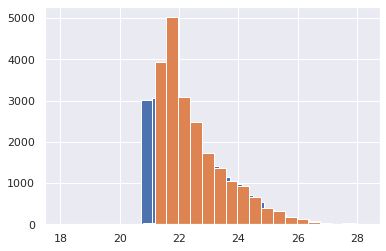

In [138]:
plt.hist(np.log(X['marketcap']), bins=20, alpha=1.)
plt.hist(np.log(pred), bins=25, alpha=1.)

plt.show()

In [173]:
last_df = pred_df.sort_values('date', ascending=False)
last_df.index = range(len(last_df))
last_df = last_df.drop_duplicates('ticker', keep='first')
last_df.index = range(len(last_df))
last_df['ratio'] = last_df['pred_marketcap'] / last_df['marketcap']
last_df = last_df.sort_values('ratio', ascending=False)
last_df.index = range(len(last_df))

In [174]:
last_df.groupby('sector')['ratio'].median().reset_index().sort_values('ratio', ascending=False)

,sector,ratio
4,Energy,1.584269
1,Communication Services,1.371506
6,Healthcare,1.361561
5,Financial Services,1.354275
2,Consumer Cyclical,1.277036
7,Industrials,1.275609
8,Real Estate,1.244327
10,Utilities,1.199157
0,Basic Materials,1.197555
9,Technology,1.158866


In [156]:
last_df['sector'].unique()

array(['Financial Services', 'Technology', 'Healthcare',
       'Consumer Defensive', 'Real Estate', 'Energy', 'Industrials',
       'Basic Materials', 'Consumer Cyclical', 'Communication Services',
       'Utilities', nan], dtype=object)

In [180]:
last_df[last_df['ticker']=='LYFT']

,ticker,date,marketcap,pred_marketcap,sector,ratio
641,LYFT,2020-11-12,1.156101e+10,2.163663e+10,Technology,1.871517


In [181]:
last_df[last_df['ticker']=='UBER']

,ticker,date,marketcap,pred_marketcap,sector,ratio
2670,UBER,2020-11-06,7.914027e+10,2.823983e+10,Technology,0.356833


In [183]:
last_df[last_df['sector']=='Energy'][:30]

,ticker,date,marketcap,pred_marketcap,sector,ratio
7,AR,2019-07-31,1.425513e+09,1.266648e+10,Energy,8.885557
14,CRCQQ,2019-02-27,1.061552e+09,7.847266e+09,Energy,7.392257
15,HKRSQ,2017-11-09,1.000798e+09,7.275217e+09,Energy,7.269418
19,GPORQ,2019-05-03,1.086544e+09,6.692623e+09,Energy,6.159549
22,CHKAQ,2019-11-05,2.501328e+09,1.469652e+10,Energy,5.875485
26,CRZO,2019-05-09,1.139655e+09,6.187291e+09,Energy,5.429093
28,TUSK,2018-11-02,1.206613e+09,6.348070e+09,Energy,5.261065
50,WFTIQ,2018-11-02,1.241144e+09,5.524651e+09,Energy,4.451257
51,RIG,2020-07-30,1.278394e+09,5.683222e+09,Energy,4.445595
56,PAGP,2020-11-06,1.258169e+09,5.405158e+09,Energy,4.296052


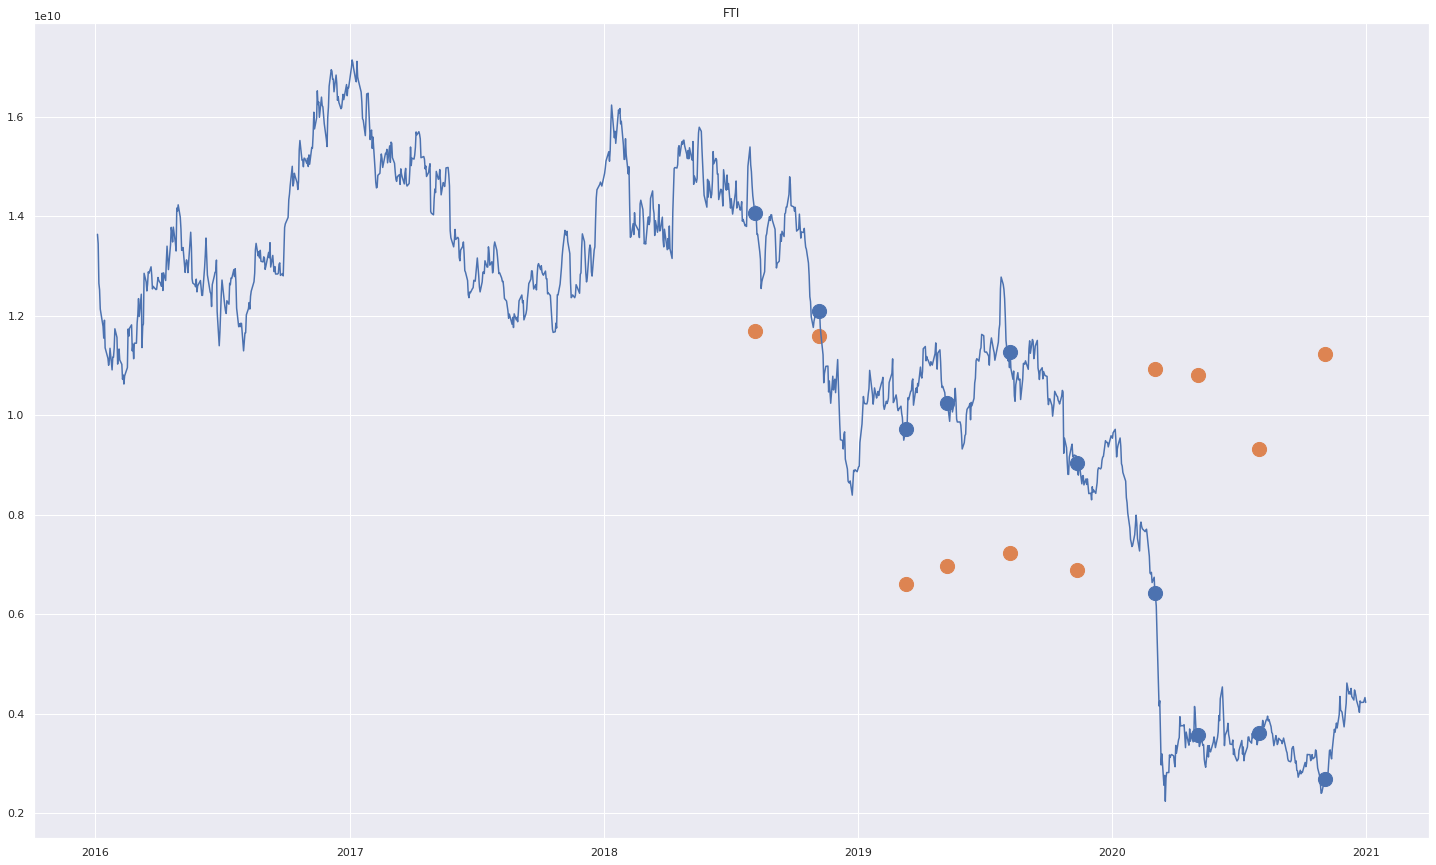

In [184]:
ticker = 'FTI'

daily_df = load_cf1_df('{}/cf1/daily/{}.json'.format(config['data_path'], ticker))
X_curr = X[X['ticker']==ticker]
pred_curr = pred_df[pred_df['ticker']==ticker]


plt.figure(figsize=(25,15))
plt.title(ticker)
plt.plot([np.datetime64(x) for x in daily_df['date']][::-1], daily_df['marketcap'].values[::-1] * 1e6)
plt.scatter([np.datetime64(x) for x in X_curr['date']][::-1], X_curr['marketcap'].values[::-1], s=200)
plt.scatter([np.datetime64(x) for x in pred_curr['date']][::-1], pred_curr['pred_marketcap'].values[::-1], s=200)

In [ ]:
NLOK PFPT

In [161]:
X[X['ticker']=='DBD']

,ticker,date,marketcap,quarter2_revenue_mean,quarter2_revenue_max,quarter2_revenue_min,quarter2_revenue_std,quarter2_netinc_mean,quarter2_netinc_max,quarter2_netinc_min,...,quarter10_workingcapital_std,quarter10_cashneq_mean,quarter10_cashneq_max,quarter10_cashneq_min,quarter10_cashneq_std,quarter10_rnd_mean,quarter10_rnd_max,quarter10_rnd_min,quarter10_rnd_std,sector
20394,DBD,2019-07-30,1.084422e+09,1.089150e+09,1.150200e+09,-9.223372e+18,61050000.0,-91500000.0,-50300000.0,-9.223372e+18,...,1.461151e+08,405820000.0,535200000.0,-9.223372e+18,8.134164e+07,38590000.0,41700000.0,-9.223372e+18,2.454567e+06,10


In [108]:
base_models = []
for k in range(5):
    base_models.append(deepcopy(lgb))

In [109]:
for k in range(5):
    base_models[k].fit(np.random.randint(0, 10, 40).reshape(10, 4), np.random.randint(0, 100, 10))

In [110]:
a = np.random.randint(0, 10, 4).reshape(1, 4)

In [111]:
base_models[0].predict(a)

array([56.5])

In [113]:
base_models[1].predict(a)

array([54.3])

In [96]:
np.random.randint(0,100, 1000).reshape(200, 5)

array([[91, 19, 89, 56, 86],
       [96, 22, 99, 77, 56],
       [69, 86, 32, 96, 72],
       [96, 21, 62, 31, 86],
       [47,  6, 95, 40, 27],
       [98, 61, 24, 85, 23],
       [36, 39, 72, 37,  8],
       [53, 16, 71, 24, 91],
       [58, 88, 10,  4,  1],
       [89, 53,  5, 18, 35],
       [65, 74, 23, 69, 79],
       [78,  6, 84, 54, 62],
       [45, 20, 83, 89, 62],
       [20, 52, 15, 53, 55],
       [61, 32, 33,  5,  3],
       [71, 83, 97,  0, 51],
       [81, 99, 45, 64, 78],
       [26, 39, 22, 60, 58],
       [92, 41, 97, 81, 27],
       [ 2, 90, 22, 68, 20],
       [86,  0, 67, 23, 45],
       [73, 62, 10, 57, 32],
       [72, 17, 14, 84, 75],
       [68, 30, 49, 99, 93],
       [51,  6, 62,  7, 11],
       [12, 18, 39, 82, 38],
       [19, 60, 77, 14,  2],
       [ 1, 59, 52, 76, 56],
       [85, 72, 53, 62, 59],
       [74, 13, 79, 96, 65],
       [69, 42, 73,  7, 36],
       [85,  1, 10, 51, 61],
       [41, 48, 97, 56, 91],
       [33, 98, 38, 75, 27],
       [38, 93

In [57]:
price_data = {np.datetime64(x['date']):x['close'] for x in data['historical']}

{numpy.datetime64('2020-12-24'): 40.529999,
 numpy.datetime64('2020-12-23'): 39.669998,
 numpy.datetime64('2020-12-22'): 39.009998,
 numpy.datetime64('2020-12-21'): 36.220001,
 numpy.datetime64('2020-12-18'): 37.130001,
 numpy.datetime64('2020-12-17'): 39.82,
 numpy.datetime64('2020-12-16'): 40.400002,
 numpy.datetime64('2020-12-15'): 39.990002,
 numpy.datetime64('2020-12-14'): 39.639999,
 numpy.datetime64('2020-12-11'): 37.459999,
 numpy.datetime64('2020-12-10'): 37.549999,
 numpy.datetime64('2020-12-09'): 37.889999,
 numpy.datetime64('2020-12-08'): 36.59,
 numpy.datetime64('2020-12-07'): 36.049999,
 numpy.datetime64('2020-12-04'): 36.669998,
 numpy.datetime64('2020-12-03'): 34.880001,
 numpy.datetime64('2020-12-02'): 34.880001,
 numpy.datetime64('2020-12-01'): 33.950001,
 numpy.datetime64('2020-11-30'): 34.459999,
 numpy.datetime64('2020-11-27'): 35.57,
 numpy.datetime64('2020-11-25'): 34.990002,
 numpy.datetime64('2020-11-24'): 37.150002,
 numpy.datetime64('2020-11-23'): 36.139999,


In [78]:
%%time
arr = []
for ticker in tqdm(ticker_list):
    data = load_json('{}/historical_price_full/{}.json'.format(config['data_path'], ticker))
    arr.append(data)

100%|██████████| 8899/8899 [00:17<00:00, 522.01it/s]

CPU times: user 11.2 s, sys: 1.89 s, total: 13.1 s
Wall time: 17 s


In [ ]:
def price_to_mktCap(ticker):
    None

In [146]:
dates = np.array([np.datetime64(x['date']) for x in price_data['historical']])
prices = np.array([x['close'] for x in price_data['historical']])
caps = prices * enterprise_data[0]['numberOfShares']
cap_df = pd.DataFrame()
cap_df['date'] = dates
cap_df['marketCapitalization'] = caps

In [174]:
"2020-06-27"
date_to_price = {x['date']:x['close'] for x in price_data['historical']}

In [176]:
date_to_price

{'2020-12-24': 131.970001,
 '2020-12-23': 130.960007,
 '2020-12-22': 131.880005,
 '2020-12-21': 128.229996,
 '2020-12-18': 126.660004,
 '2020-12-17': 128.699997,
 '2020-12-16': 127.809998,
 '2020-12-15': 127.879997,
 '2020-12-14': 121.779999,
 '2020-12-11': 122.410004,
 '2020-12-10': 123.239998,
 '2020-12-09': 121.779999,
 '2020-12-08': 124.379997,
 '2020-12-07': 123.75,
 '2020-12-04': 122.25,
 '2020-12-03': 122.940002,
 '2020-12-02': 123.080002,
 '2020-12-01': 122.720001,
 '2020-11-30': 119.050003,
 '2020-11-27': 116.589996,
 '2020-11-25': 116.029999,
 '2020-11-24': 115.169998,
 '2020-11-23': 113.849998,
 '2020-11-20': 117.339996,
 '2020-11-19': 118.639999,
 '2020-11-18': 118.029999,
 '2020-11-17': 119.389999,
 '2020-11-16': 120.300003,
 '2020-11-13': 119.260002,
 '2020-11-12': 119.209999,
 '2020-11-11': 119.489998,
 '2020-11-10': 115.970001,
 '2020-11-09': 116.32,
 '2020-11-06': 118.690002,
 '2020-11-05': 119.029999,
 '2020-11-04': 114.949997,
 '2020-11-03': 110.440002,
 '2020-11-02'

In [175]:
date_to_price['2020-06-27']

KeyError: '2020-06-27'

In [151]:
cap_df

,date,marketCapitalization
0,2020-12-24,2.289959e+12
1,2020-12-23,2.272434e+12
2,2020-12-22,2.288398e+12
3,2020-12-21,2.225062e+12
4,2020-12-18,2.197819e+12
...,...,...
10090,1980-12-18,2.062508e+09
10091,1980-12-17,2.004395e+09
10092,1980-12-16,1.955983e+09
10093,1980-12-15,2.110920e+09


In [149]:
cap_df.shape

(10095, 2)

In [169]:
4312573000 * 4

17250292000

In [171]:
17352119000 * 112.279999

1948295903967.881

In [ ]:
1948295903967
381263801810

In [172]:
88.407501 * 4312573000

381263801810.073

In [ ]:
  "stockPrice" : 112.279999,
  "numberOfShares" : 17352119000,
  "marketCapitalization" : 1948295903967.881,

  "stockPrice" : 88.407501,
  "numberOfShares" : 4312573000,
  "marketCapitalization" : 381263801810.073,

In [ ]:
tmp = cap_df[:2000]
plt.figure(figsize=(25,15))
plt.plot(tmp['date'], tmp['marketCapitalization'])

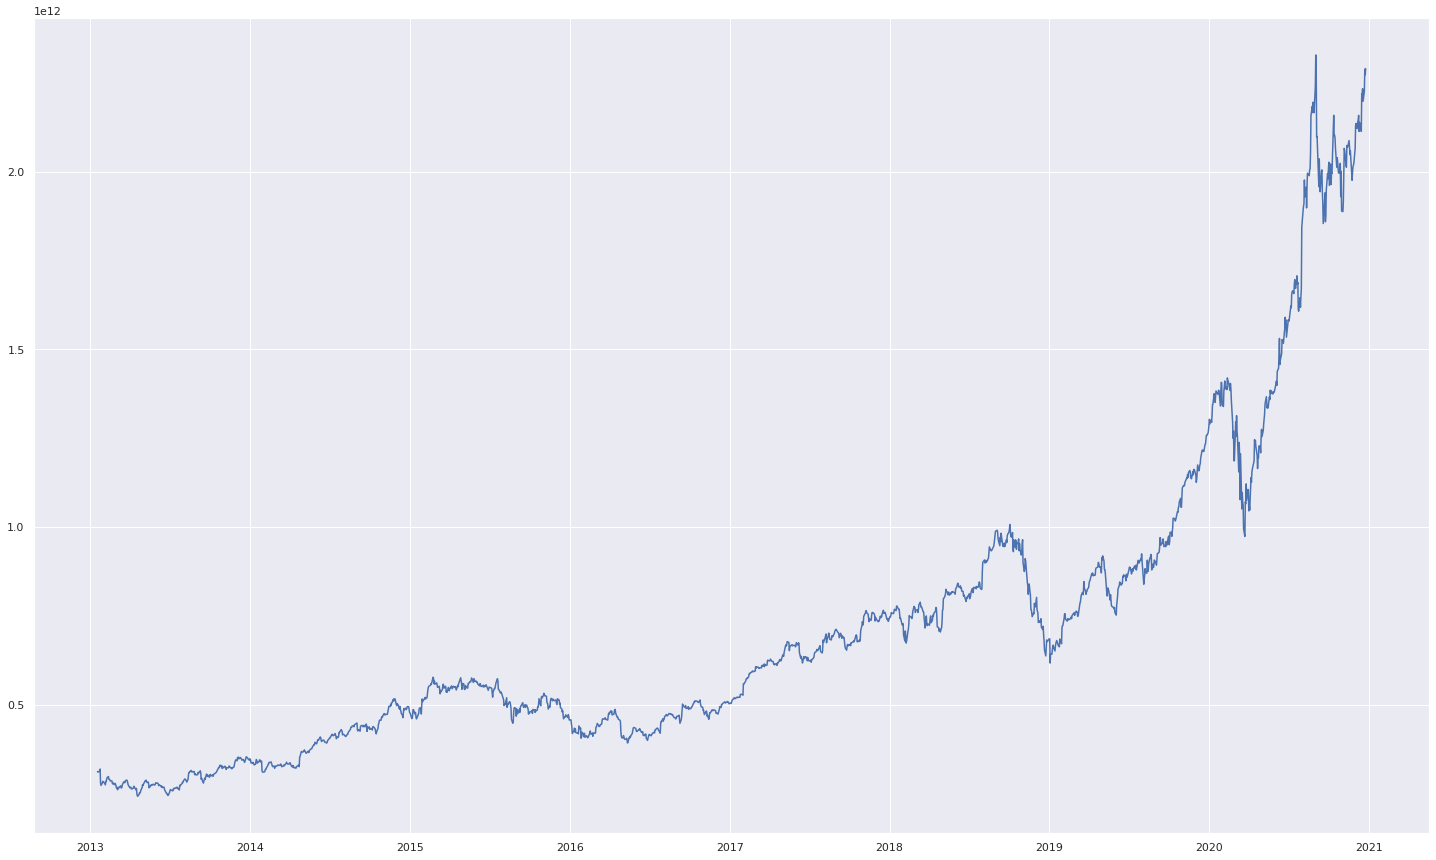

In [152]:
tmp = cap_df[:2000]
plt.figure(figsize=(25,15))
plt.plot(tmp['date'], tmp['marketCapitalization'])

In [153]:
tmp

,date,marketCapitalization
0,2020-12-24,2.289959e+12
1,2020-12-23,2.272434e+12
2,2020-12-22,2.288398e+12
3,2020-12-21,2.225062e+12
4,2020-12-18,2.197819e+12
...,...,...
1995,2013-01-24,2.791832e+11
1996,2013-01-23,3.185415e+11
1997,2013-01-22,3.128153e+11
1998,2013-01-18,3.098593e+11


In [168]:
cap_df[2700:2750]

,date,marketCapitalization
2700,2010-04-07,1.491043e+11
2701,2010-04-06,1.484474e+11
2702,2010-04-05,1.477967e+11
2703,2010-04-01,1.462350e+11
2704,2010-03-31,1.456339e+11
2705,2010-03-30,1.461606e+11
2706,2010-03-29,1.440164e+11
2707,2010-03-26,1.430930e+11
2708,2010-03-25,1.404592e+11
2709,2010-03-24,1.421448e+11


In [123]:
len(date_to_cap)

7872

In [124]:
len(dates)

10095

In [118]:
prices

array([1.31970001e+02, 1.30960007e+02, 1.31880005e+02, ...,
       1.12723000e-01, 1.21652000e-01, 1.28348000e-01])

In [127]:
date_to_cap

{numpy.datetime64('1989-12-29'): 4564872928.0,
 numpy.datetime64('1989-12-28'): 4497543296.0,
 numpy.datetime64('1989-12-27'): 4562485568.0,
 numpy.datetime64('1989-12-26'): 4611192272.0,
 numpy.datetime64('1989-12-22'): 4741091364.0,
 numpy.datetime64('1989-12-21'): 4708620228.0,
 numpy.datetime64('1989-12-20'): 4643663408.0,
 numpy.datetime64('1989-12-19'): 4546250000.0,
 numpy.datetime64('1989-12-18'): 4513778864.0,
 numpy.datetime64('1989-12-15'): 4383879772.0,
 numpy.datetime64('1989-12-14'): 4530014432.0,
 numpy.datetime64('1989-12-13'): 4676149092.0,
 numpy.datetime64('1989-12-12'): 4676149092.0,
 numpy.datetime64('1989-12-11'): 5098288408.0,
 numpy.datetime64('1989-12-08'): 5423028864.0,
 numpy.datetime64('1989-12-07'): 5552913408.0,
 numpy.datetime64('1989-12-06'): 5552913408.0,
 numpy.datetime64('1989-12-05'): 5845182728.0,
 numpy.datetime64('1989-12-04'): 5877653864.0,
 numpy.datetime64('1989-12-01'): 5715283636.0,
 numpy.datetime64('1989-11-30'): 5747754772.0,
 numpy.dateti

In [107]:
(dates <= quarter_dates[k+1]) 

array([False, False, False, ...,  True,  True,  True])

In [105]:
quarter_dates[k+1]

numpy.datetime64('1989-12-29')

In [108]:
quarter_dates[k]

numpy.datetime64('1989-09-29')

In [106]:
dates

array(['2020-12-24', '2020-12-23', '2020-12-22', ..., '1980-12-16',
       '1980-12-15', '1980-12-12'], dtype='datetime64[D]')

In [82]:
price_data['historical']

[{'date': '2020-12-24', 'close': 131.970001},
 {'date': '2020-12-23', 'close': 130.960007},
 {'date': '2020-12-22', 'close': 131.880005},
 {'date': '2020-12-21', 'close': 128.229996},
 {'date': '2020-12-18', 'close': 126.660004},
 {'date': '2020-12-17', 'close': 128.699997},
 {'date': '2020-12-16', 'close': 127.809998},
 {'date': '2020-12-15', 'close': 127.879997},
 {'date': '2020-12-14', 'close': 121.779999},
 {'date': '2020-12-11', 'close': 122.410004},
 {'date': '2020-12-10', 'close': 123.239998},
 {'date': '2020-12-09', 'close': 121.779999},
 {'date': '2020-12-08', 'close': 124.379997},
 {'date': '2020-12-07', 'close': 123.75},
 {'date': '2020-12-04', 'close': 122.25},
 {'date': '2020-12-03', 'close': 122.940002},
 {'date': '2020-12-02', 'close': 123.080002},
 {'date': '2020-12-01', 'close': 122.720001},
 {'date': '2020-11-30', 'close': 119.050003},
 {'date': '2020-11-27', 'close': 116.589996},
 {'date': '2020-11-25', 'close': 116.029999},
 {'date': '2020-11-24', 'close': 115.16999

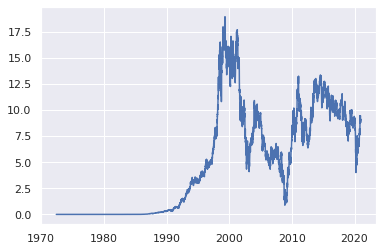

In [38]:
price_list = [x['close'] for x in data['historical']]
date_list = [np.datetime64(x['date']) for x in data['historical']]

plt.plot(date_list, price_list)

In [29]:
len(data)

2

In [25]:
data

[{'symbol': 'AAPL',
  'date': '2020-09-26',
  'stockPrice': 112.279999,
  'numberOfShares': 17352119000,
  'marketCapitalization': 1948295903967.881,
  'minusCashAndCashEquivalents': 38016000000,
  'addTotalDebt': 107440000000,
  'enterpriseValue': 2017719903967.881},
 {'symbol': 'AAPL',
  'date': '2020-06-27',
  'stockPrice': 88.407501,
  'numberOfShares': 4312573000,
  'marketCapitalization': 381263801810.073,
  'minusCashAndCashEquivalents': 33383000000,
  'addTotalDebt': 105844000000,
  'enterpriseValue': 453724801810.073},
 {'symbol': 'AAPL',
  'date': '2020-03-28',
  'stockPrice': 61.935001,
  'numberOfShares': 4360101000,
  'marketCapitalization': 270042859795.101,
  'minusCashAndCashEquivalents': 40174000000,
  'addTotalDebt': 99744000000,
  'enterpriseValue': 329612859795.101},
 {'symbol': 'AAPL',
  'date': '2019-12-28',
  'stockPrice': 72.449997,
  'numberOfShares': 4617834000,
  'marketCapitalization': 334562059446.498,
  'minusCashAndCashEquivalents': 39771000000,
  'addTot

In [21]:
data

[{'symbol': 'SHOP',
  'date': '2020-09-30',
  'stockPrice': 1022.969971,
  'numberOfShares': 120511484,
  'marketCapitalization': 123279629292.64696,
  'minusCashAndCashEquivalents': 3089884000,
  'addTotalDebt': 3781729000,
  'enterpriseValue': 123971474292.64696},
 {'symbol': 'SHOP',
  'date': '2020-06-30',
  'stockPrice': 949.2,
  'numberOfShares': 118740645,
  'marketCapitalization': 112708620234,
  'minusCashAndCashEquivalents': 1882362000,
  'addTotalDebt': 2118593000,
  'enterpriseValue': 112944851234},
 {'symbol': 'SHOP',
  'date': '2020-04-21',
  'stockPrice': 585.0,
  'numberOfShares': 0.0,
  'marketCapitalization': 0.0,
  'minusCashAndCashEquivalents': 4000.0,
  'addTotalDebt': 0.0,
  'enterpriseValue': -4000.0},
 {'symbol': 'SHOP',
  'date': '2020-03-31',
  'stockPrice': 416.93,
  'numberOfShares': 116806549,
  'marketCapitalization': 48700154474.57,
  'minusCashAndCashEquivalents': 969363000,
  'addTotalDebt': 1391209000,
  'enterpriseValue': 49122000474.57},
 {'symbol': '

In [20]:
len(data)

24

In [128]:
len(common_dates)

27

In [5]:
arr = []
profile_filenames = os.listdir('{}/key_metrics_ttm'.format(config['data_path']))
for filename in profile_filenames:
    curr = load_json('{}/key_metrics_ttm/{}'.format(config['data_path'], filename))
    if type(curr) == list and len(curr) > 0:
        curr[0]['symbol'] = filename.split('.')[0]
        arr.append(curr[0])
        
metrics_last_df = pd.DataFrame(arr)
#metrics_last_df = metrics_last_df.fillna(metrics_last_df.mean(axis=0))

def create_profile_df(config):
    arr = []
    profile_filenames = os.listdir('{}/profile'.format(config['data_path']))
    for filename in profile_filenames:
        curr = load_json('{}/profile/{}'.format(config['data_path'], filename))
        if type(curr) == list:
            arr.extend(curr)

    df = pd.DataFrame(arr)
    
    return df

In [127]:
[x for x in data if np.datetime64(x['date']) in common_dates]

[{'date': '2020-09-30',
  'symbol': 'SHOP',
  'fillingDate': '2020-09-30',
  'acceptedDate': '2020-09-30',
  'period': 'Q3',
  'netIncome': 191068000,
  'depreciationAndAmortization': 17870000,
  'deferredIncomeTax': 19326000,
  'stockBasedCompensation': 63807000,
  'changeInWorkingCapital': -68634000,
  'accountsReceivables': 0.0,
  'inventory': 0.0,
  'accountsPayables': 0.0,
  'otherWorkingCapital': -4245000.0,
  'otherNonCashItems': 0.0,
  'netCashProvidedByOperatingActivities': 99357000,
  'investmentsInPropertyPlantAndEquipment': 0.0,
  'acquisitionsNet': 0.0,
  'purchasesOfInvestments': -1690399000,
  'salesMaturitiesOfInvestments': 777057000,
  'otherInvestingActivites': 0.0,
  'netCashUsedForInvestingActivites': 0.0,
  'debtRepayment': 0.0,
  'commonStockIssued': 1117646000,
  'commonStockRepurchased': 0.0,
  'dividendsPaid': 0.0,
  'otherFinancingActivites': 0.0,
  'netCashUsedProvidedByFinancingActivities': 0.0,
  'effectOfForexChangesOnCash': 45000.0,
  'netChangeInCash': 0

In [110]:
np.datetime64(dates[0])

numpy.datetime64('2017-06-30')

In [120]:
dates

[numpy.datetime64('2014-03-31'),
 numpy.datetime64('2014-06-30'),
 numpy.datetime64('2014-09-30'),
 numpy.datetime64('2014-12-31'),
 numpy.datetime64('2015-03-31'),
 numpy.datetime64('2015-06-30'),
 numpy.datetime64('2015-09-30'),
 numpy.datetime64('2015-12-31'),
 numpy.datetime64('2016-03-31'),
 numpy.datetime64('2016-06-30'),
 numpy.datetime64('2016-09-30'),
 numpy.datetime64('2016-12-31'),
 numpy.datetime64('2017-03-31'),
 numpy.datetime64('2017-06-30'),
 numpy.datetime64('2017-09-30'),
 numpy.datetime64('2017-12-31'),
 numpy.datetime64('2018-03-31'),
 numpy.datetime64('2018-06-30'),
 numpy.datetime64('2018-09-30'),
 numpy.datetime64('2018-12-31'),
 numpy.datetime64('2019-03-31'),
 numpy.datetime64('2019-06-30'),
 numpy.datetime64('2019-09-30'),
 numpy.datetime64('2019-12-31'),
 numpy.datetime64('2020-03-31'),
 numpy.datetime64('2020-06-30'),
 numpy.datetime64('2020-09-30')]

In [104]:
arr

[{'2019-09-30', '2019-12-31', '2020-06-30', '2020-09-30'},
 {'2018-01-31',
  '2018-03-31',
  '2018-06-31',
  '2018-09-31',
  '2019-01-31',
  '2019-03-31',
  '2019-06-31',
  '2019-09-31',
  '2020-06-30'}]

In [94]:
ticker = 'LXEH'
data = load_json('{}/income_statement/{}.json'.format(config['data_path'], ticker))
[x['date'] for x in data]

['2020-09-30', '2020-06-30', '2019-12-31', '2019-09-30']

In [92]:
data = load_json('{}/cash_flow_statement/{}.json'.format(config['data_path'], ticker))
[x['date'] for x in data]

['2020-06-30',
 '2019-09-31',
 '2019-06-31',
 '2019-03-31',
 '2019-01-31',
 '2018-09-31',
 '2018-06-31',
 '2018-03-31',
 '2018-01-31']

In [83]:
X[X['income_statement_date'] != X['cash_flow_statement_date']][['ticker', 'back_quarter']+date_cols]

,ticker,back_quarter,income_statement_date,cash_flow_statement_date
254,SHOP,2,2020-03-31,2020-04-21
255,SHOP,3,2019-12-31,2020-03-31
256,SHOP,4,2019-09-30,2019-12-31
257,SHOP,5,2019-06-30,2019-09-30
258,SHOP,6,2019-03-31,2019-06-30
...,...,...,...,...
49632,LXEH,1,2020-06-30,2019-09-31
49633,LXEH,2,2019-12-31,2019-06-31
49634,LXEH,3,2019-09-30,2019-03-31
49670,HX,2,2019-06-30,2018-03-31


In [85]:
X[X['income_statement_date'] != X['cash_flow_statement_date']]['ticker'].unique().shape

(224,)

In [10]:
pd.DataFrame(X)

,quarter10_revenue_mean,quarter10_revenue_max,quarter10_revenue_min,quarter10_revenue_std,quarter10_netIncome_mean,quarter10_netIncome_max,quarter10_netIncome_min,quarter10_netIncome_std,quarter20_revenue_mean,quarter20_revenue_max,...,quarter10_freeCashFlow_min,quarter10_freeCashFlow_std,quarter20_freeCashFlow_mean,quarter20_freeCashFlow_max,quarter20_freeCashFlow_min,quarter20_freeCashFlow_std,quarter40_freeCashFlow_mean,quarter40_freeCashFlow_max,quarter40_freeCashFlow_min,quarter40_freeCashFlow_std
0,4.351800e+09,4.810000e+09,3.974000e+09,2.642112e+08,3.515000e+08,696000000.0,110000000.0,1.990458e+08,4.216100e+09,4.939000e+09,...,-700000000.0,3.859225e+08,-2.660000e+08,517000000.0,-732000000.0,3.747705e+08,-2.000667e+08,517000000.0,-732000000.0,3.521873e+08
1,6.563016e+08,7.931400e+08,5.703910e+08,6.450645e+07,2.927420e+07,66536000.0,-1988000.0,2.286761e+07,5.909209e+08,7.931400e+08,...,-339335000.0,3.056471e+08,3.768365e+07,541555000.0,-344709000.0,2.842774e+08,1.313732e+07,541555000.0,-344709000.0,2.403912e+08
2,1.395044e+08,1.489200e+08,1.248420e+08,8.673356e+06,4.630950e+07,114763000.0,-9100000.0,3.948676e+07,1.432620e+08,1.541180e+08,...,22473000.0,1.049097e+07,5.028300e+07,66171000.0,22473000.0,1.037399e+07,5.081555e+07,130788000.0,20706000.0,2.177628e+07
3,3.881700e+08,4.982000e+08,2.865000e+08,5.741592e+07,2.994000e+07,80900000.0,9200000.0,2.021189e+07,3.694150e+08,4.982000e+08,...,-8700000.0,4.152082e+07,5.222500e+07,123900000.0,-8700000.0,3.616802e+07,4.709697e+07,123900000.0,-8700000.0,3.291591e+07
4,9.150100e+08,1.102100e+09,7.152000e+08,1.192812e+08,6.327000e+07,115500000.0,11300000.0,3.768528e+07,8.840650e+08,1.102100e+09,...,-132500000.0,1.348968e+08,5.358500e+07,242100000.0,-142300000.0,1.193232e+08,4.003000e+07,242100000.0,-156200000.0,1.028003e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4274,1.600000e+04,1.300000e+05,0.000000e+00,3.826225e+04,-3.400000e+05,-190000.0,-450000.0,9.121403e+04,1.333333e+04,1.300000e+05,...,-550000.0,1.279383e+05,-3.027613e+05,-3500.0,-550000.0,1.775998e+05,-3.027613e+05,-3500.0,-550000.0,1.775998e+05
4275,2.231000e+07,2.910000e+07,1.820000e+07,3.164949e+06,-1.190000e+06,21000000.0,-5500000.0,7.523889e+06,4.632000e+07,9.310000e+07,...,-7150000.0,2.287233e+06,-2.784000e+06,1940000.0,-7150000.0,2.478775e+06,-2.013750e+06,6810000.0,-13170000.0,4.015161e+06
4276,5.783311e+05,1.966000e+06,-3.691351e+06,1.649307e+06,-2.692807e+06,25182000.0,-9322000.0,1.104442e+07,5.783311e+05,1.966000e+06,...,-9789000.0,1.094909e+07,-1.662123e+06,22843000.0,-9789000.0,1.094909e+07,-1.662123e+06,22843000.0,-9789000.0,1.094909e+07
4277,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.739113e+06,6558871.0,-29650000.0,8.890807e+06,1.650000e+04,1.900000e+05,...,-5590000.0,1.495672e+06,-2.890000e+06,-1230000.0,-5590000.0,1.208048e+06,-2.345000e+06,-770000.0,-5590000.0,1.129150e+06


In [15]:
calc_feats(ticker='TCS', backshift_cnt=10, config=config)

TypeError: calc_feats() got an unexpected keyword argument 'backshift_cnt'

In [106]:
%%time
data = load_json('data/income_statement/AAPL.json')
data = load_json('data/cash_flow_statement/AAPL.json')

CPU times: user 902 µs, sys: 3.19 ms, total: 4.09 ms
Wall time: 3.57 ms


In [113]:
config

{'data_path': 'data',
 'fmp_api_url': 'https://financialmodelingprep.com/api/v3',
 'fmp_api_key': 'd83f574477738fc35b34bde9292fcc1c'}

In [126]:
quarter_cnt = 20
backshift_cnt = 0
ticker = 'AAPL'

In [127]:
feats

{'revenue_mean': 62257850000.0,
 'revenue_max': 91819000000,
 'revenue_min': 42358000000,
 'revenue_std': 14001883977.790274,
 'netIncome_mean': 13311800000.0,
 'netIncome_max': 22236000000,
 'netIncome_min': 7796000000,
 'netIncome_std': 4078483904.5900373}

In [124]:
curr_feats

{'netIncome_mean': 13311800000.0,
 'netIncome_max': 22236000000,
 'netIncome_min': 7796000000,
 'netIncome_std': 4078483904.5900373}

In [ ]:
"revenue" : 64698000000,
"costOfRevenue" : 40009000000,
"grossProfit" : 24689000000,
"grossProfitRatio" : 0.38160375900337,
"researchAndDevelopmentExpenses" : 4978000000,
"generalAndAdministrativeExpenses" : 4936000000,
"sellingAndMarketingExpenses" : 0.0,
"otherExpenses" : 126000000,
"operatingExpenses" : 9914000000,
"costAndExpenses" : 49923000000,
"interestExpense" : 0.0,
"depreciationAndAmortization" : 2702000000,
"ebitda" : 17477000000,
"ebitdaratio" : 0.270131997897926,
"operatingIncome" : 14775000000,
"operatingIncomeRatio" : 0.228368728554206,
"totalOtherIncomeExpensesNet" : 126000000,
"incomeBeforeTax" : 14901000000,
"incomeBeforeTaxRatio" : 0.230316238523602,
"incomeTaxExpense" : 2228000000,
"netIncome" : 12673000000,
"netIncomeRatio" : 0.195879316207611,

In [108]:
series

array([18361000000, 10516000000,  7796000000,  9014000000, 17891000000,
       11029000000,  8717000000, 10714000000, 20065000000, 13822000000,
       11519000000, 14125000000, 19965000000, 11561000000, 10044000000,
       13686000000, 22236000000, 11249000000, 11253000000, 12673000000])

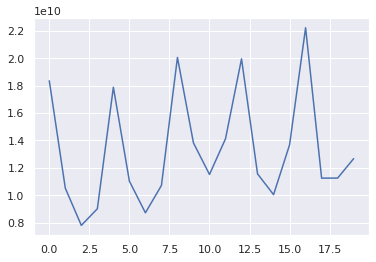

In [103]:
plt.plot(series)

In [94]:
series.max()

22236000000

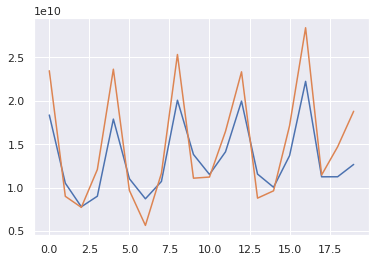

In [90]:
plt.plot([x['netIncome'] for x in data][::-1][-20:])
# plt.plot([x['ebitda'] for x in data][::-1][-20:])
# plt.plot([x['revenue'] for x in data][::-1][-20:])
plt.plot([x['freeCashFlow'] for x in data][::-1][-20:])

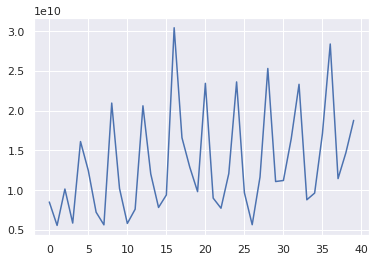

In [88]:
plt.plot([x['freeCashFlow'] for x in data][::-1][-40:])

In [78]:
90943000000 + 16120000000 + 4061000000 + 32589000000

143713000000

In [79]:
36766000000 + 100887000000 + 42522000000

180175000000

In [86]:
90482000000 + 180175000000 + 143713000000

414370000000

In [ ]:
  "date" : "2020-09-26",
  "symbol" : "AAPL",
  "fillingDate" : "2020-10-30",
  "acceptedDate" : "2020-10-29 18:06:25",
  "period" : "Q4",
  "cashAndCashEquivalents" : 38016000000,
  "shortTermInvestments" : 52927000000,
  "cashAndShortTermInvestments" : 90943000000,
  "netReceivables" : 16120000000,
  "inventory" : 4061000000,
  "otherCurrentAssets" : 32589000000,
  "totalCurrentAssets" : 143713000000,
  "propertyPlantEquipmentNet" : 36766000000,
  "goodwill" : 0.0,
  "intangibleAssets" : 0.0,
  "goodwillAndIntangibleAssets" : 0.0,
  "longTermInvestments" : 100887000000,
  "taxAssets" : 0.0,
  "otherNonCurrentAssets" : 42522000000,
  "totalNonCurrentAssets" : 180175000000,
  "otherAssets" : 90482000000,
  "totalAssets" : 323888000000,
  "accountPayables" : 42296000000,
  "shortTermDebt" : 8773000000,
  "taxPayables" : 0.0,
  "deferredRevenue" : 6643000000,
  "otherCurrentLiabilities" : 47680000000,
  "totalCurrentLiabilities" : 105392000000,
  "longTermDebt" : 98667000000,
  "deferredRevenueNonCurrent" : 0.0,
  "deferredTaxLiabilitiesNonCurrent" : 0.0,
  "otherNonCurrentLiabilities" : 54490000000,
  "totalNonCurrentLiabilities" : 153157000000,
  "otherLiabilities" : 0.0,
  "totalLiabilities" : 258549000000,
  "commonStock" : 16976763000,
  "retainedEarnings" : 14966000000,
  "accumulatedOtherComprehensiveIncomeLoss" : -406000000,
  "othertotalStockholdersEquity" : 33802237000,
  "totalStockholdersEquity" : 65339000000,
  "totalLiabilitiesAndStockholdersEquity" : 323888000000,
  "totalInvestments" : 153814000000,
  "totalDebt" : 107440000000,
  "netDebt" : 69424000000,
  "link" : "https://www.sec.gov/Archives/edgar/data/320193/000032019320000096/0000320193-20-000096-index.htm",
  "finalLink" : "https://www.sec.gov/Archives/edgar/data/320193/000032019320000096/aapl-20200926.htm"

In [81]:
98667000000 / 65339000000


1.5100782075024104

In [74]:
64698000000 - 49923000000 - 2702000000

12073000000

In [76]:
#40009000000
4978000000 + 4936000000 + 126000000 #+ 49923000000 + 2702000000

10040000000

In [77]:
4312573000 * 4

17250292000

In [75]:
40009000000 + 19954000000

59963000000

In [ ]:
64698000000
72579000000
49923000000


In [12]:
data[0]

{'date': '2020-09-26',
 'symbol': 'AAPL',
 'fillingDate': '2020-10-30',
 'acceptedDate': '2020-10-29 18:06:25',
 'period': 'Q4',
 'revenue': 64698000000,
 'costOfRevenue': 40009000000,
 'grossProfit': 24689000000,
 'grossProfitRatio': 0.38160375900337,
 'researchAndDevelopmentExpenses': 4978000000,
 'generalAndAdministrativeExpenses': 4936000000,
 'sellingAndMarketingExpenses': 0.0,
 'otherExpenses': 126000000,
 'operatingExpenses': 9914000000,
 'costAndExpenses': 49923000000,
 'interestExpense': 0.0,
 'depreciationAndAmortization': 2702000000,
 'ebitda': 17477000000,
 'ebitdaratio': 0.270131997897926,
 'operatingIncome': 14775000000,
 'operatingIncomeRatio': 0.228368728554206,
 'totalOtherIncomeExpensesNet': 126000000,
 'incomeBeforeTax': 14901000000,
 'incomeBeforeTaxRatio': 0.230316238523602,
 'incomeTaxExpense': 2228000000,
 'netIncome': 12673000000,
 'netIncomeRatio': 0.195879316207611,
 'eps': 0.73,
 'epsdiluted': 0.73,
 'weightedAverageShsOut': 17352119000,
 'weightedAverageShsO

In [19]:
107440000000 / 143713000000

0.747601121680015

In [21]:
69424000000 / 38016000000

1.8261784511784511

In [22]:
98667000000 / 65339000000

1.5100782075024104

In [ ]:
14775000000
12673000000
16120000000
38016000000
180175000000
323888000000
100887000000
69424000000
4061000000
107440000000


In [8]:
load_json('data/key_metrics_ttm/AAPL.json')

[{'revenuePerShareTTM': 15.820258033039078,
  'netIncomePerShareTTM': 3.3085872682177895,
  'operatingCashFlowPerShareTTM': 1.758632475952937,
  'freeCashFlowPerShareTTM': 1.6372063838428033,
  'cashPerShareTTM': 2.190856344403816,
  'bookValuePerShareTTM': 3.765476712094932,
  'tangibleBookValuePerShareTTM': 18.66561657397578,
  'shareholdersEquityPerShareTTM': 3.765476712094932,
  'interestDebtPerShareTTM': 6.320784222376529,
  'marketCapTTM': 2308871218928.1,
  'enterpriseValueTTM': 2378295218928.1,
  'peRatioTTM': 40.2165302629827,
  'priceToSalesRatioTTM': 8.410728808728484,
  'pocfratioTTM': 75.66100468371017,
  'pfcfRatioTTM': 81.27252697835546,
  'pbRatioTTM': 35.336800669249605,
  'ptbRatioTTM': 35.336800669249605,
  'evToSalesTTM': 8.663625736036646,
  'enterpriseValueOverEBITDATTM': 29.632384985398705,
  'evToOperatingCashFlowTTM': 77.93600796067965,
  'evToFreeCashFlowTTM': 83.71625959829984,
  'earningsYieldTTM': 0.024865397224992574,
  'freeCashFlowYieldTTM': 0.0123042808

In [428]:
df_profile.shape

(8226, 32)

In [423]:
df_profile = create_profile_df(config)
df_profile = df_profile[df_profile['sector'].isnull()==False]
df_profile = df_profile[df_profile['currency']=='USD']


In [451]:
df = pd.merge(df_profile, metrics_last_df, on='symbol', how='inner')
df = df[df['peRatioTTM'] > 2]
df = df[df['peRatioTTM'] < 300]
df.shape

(2412, 90)

In [442]:
df.shape

(2479, 90)

In [393]:
df_profile.groupby('sector').size()

sector
                          2227
Basic Materials            199
Building                     1
Communication Services     236
Consumer Cyclical          504
Consumer Defensive         205
Energy                     295
Financial                    2
Financial Services        1530
Healthcare                1011
Industrial Goods             1
Industrials                960
Media                        1
N/A                         12
Real Estate                299
Technology                 631
Utilities                  112
dtype: int64

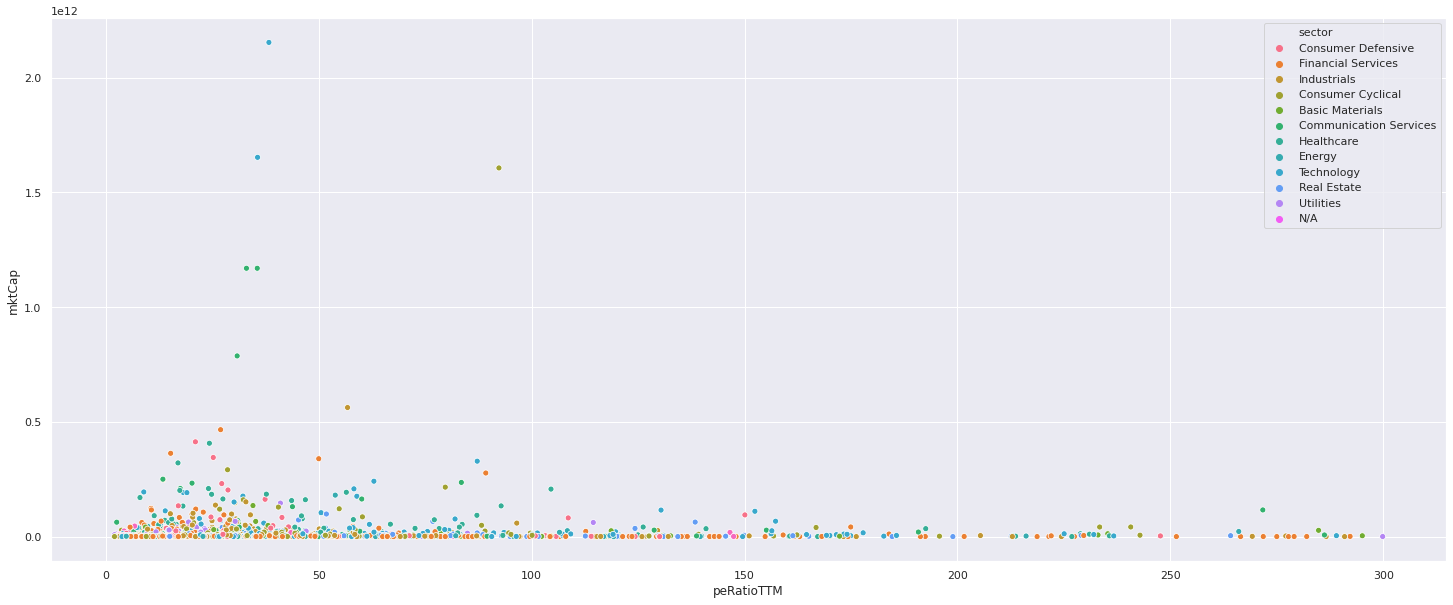

In [399]:
tmp = df[['symbol', 'peRatioTTM', 'mktCap', 'sector']]
tmp = tmp[tmp['peRatioTTM'] > 0]
tmp = tmp[tmp['peRatioTTM'] < 300]

plt.figure(figsize=(25,10))
sns.scatterplot(x='peRatioTTM', y='mktCap', data=tmp, hue="sector")

In [400]:
tmp.sort_values(['peRatioTTM'])[:50]

,symbol,peRatioTTM,mktCap,sector
8107,SECO,2.011142,1.844033e+08,Consumer Cyclical
6707,NRG,2.013330,8.252228e+09,Utilities
4238,FSTR,2.013617,1.589319e+08,Industrials
3557,FLY,2.058294,2.423247e+08,Industrials
4984,GWGH,2.088614,2.412604e+08,Financial Services
2152,DX,2.125545,4.159084e+08,Real Estate
1524,TKC,2.172014,4.526636e+09,Communication Services
5237,DVD,2.178379,7.128990e+07,Consumer Cyclical
1045,DSSI,2.206787,2.685256e+08,Energy
6387,ORGS,2.211246,1.087029e+08,Healthcare


In [475]:
tmp = df.copy()
# cols = tmp.isnull().max().reset_index()
# cols = cols[cols[0] == False]['index'].values
# tmp = tmp[cols]
tmp = tmp[tmp.columns[tmp.dtypes.values == np.dtype('float64')]]
#tmp = tmp.dropna()

In [479]:
tmp['mktCap']

0       1.625645e+11
3       1.397951e+10
9       4.728655e+09
15      2.907987e+09
21      3.657633e+10
            ...     
8176    1.119537e+09
8182    8.496872e+08
8183    1.506068e+11
8186    3.256646e+10
8192    9.884108e+09
Name: mktCap, Length: 2412, dtype: float64

In [453]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(tmp)

X = pca.transform(tmp)
X = pd.DataFrame(X)
X['sector'] = df['sector']
X['symbol'] = df['symbol']

In [480]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=10, min_samples=5).fit_predict(tmp[['peRatioTTM', 'peRatioTTM']])

In [482]:
tmp

,price,beta,volAvg,mktCap,lastDiv,changes,dcfDiff,dcf,revenuePerShareTTM,netIncomePerShareTTM,...,averagePayablesTTM,averageInventoryTTM,daysSalesOutstandingTTM,daysPayablesOutstandingTTM,daysOfInventoryOnHandTTM,receivablesTurnoverTTM,payablesTurnoverTTM,inventoryTurnoverTTM,roeTTM,capexPerShareTTM
0,367.00,0.677420,2433314.0,1.625645e+11,12.7500,-3.29,-32.86,396.74900,389.179956,9.765001,...,1.559300e+10,1.357150e+10,0.000000,10.201599,8.934644,NaN,8.822146,10.073149,0.291992,-1.226533
3,34.43,0.833220,2085159.0,1.397951e+10,0.0000,-1.12,NaN,32.62440,15.663871,2.846653,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.096881,-0.027629
9,41.56,2.030190,1010568.0,4.728655e+09,0.6100,-0.77,356.30,33.25750,18.564963,5.321977,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.103155,-9.848266
15,75.76,0.964320,146600.0,2.907987e+09,0.2000,0.89,NaN,75.76300,24.511646,2.209593,...,2.232700e+07,NaN,25.495966,3.212116,0.000000,3.529970,28.018910,NaN,0.569365,-0.061395
21,53.06,1.312220,8713965.0,3.657633e+10,0.6400,0.01,-41.01,53.95900,15.061885,7.066104,...,2.865000e+08,NaN,7.101503,11.432736,0.000000,12.673373,7.872131,NaN,1.731220,-0.135021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8176,23.17,1.204060,229162.0,1.119537e+09,2.2000,-0.73,NaN,22.23050,12.952293,1.522243,...,1.108295e+08,NaN,13.722811,149.118052,0.000000,6.558423,0.603549,NaN,0.043944,0.000000
8182,9.68,0.968180,159428.0,8.496872e+08,0.0000,-0.05,NaN,7.96305,8.492657,0.416365,...,1.074375e+08,8.793950e+07,30.653424,18.067246,13.455746,2.936050,4.981390,6.688592,0.040274,-0.381389
8183,164.07,1.102800,4192368.0,1.506068e+11,3.7200,1.38,-44.11,148.69000,14.913138,5.403909,...,4.100000e+08,2.104000e+09,9.121223,7.375872,37.184447,9.867098,12.201946,2.420367,0.597838,-0.176982
8186,116.96,0.887015,9360245.0,3.256646e+10,0.9425,-5.47,NaN,0.00000,104.423765,11.964925,...,1.633000e+09,7.365000e+08,23.092268,7.548685,2.820249,3.897408,11.922606,31.912072,0.273501,-1.016464


In [481]:
set(clustering)

{0, 1, 2}

In [422]:
df.shape

(2412, 90)

In [404]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
#X_embedded = tsne.fit_transform(metrics_last_df.drop(['symbol', 'date', 'investedCapital'], axis=1)[:])
#X_embedded = tsne.fit_transform(metrics_last_df.drop(['symbol'], axis=1)[['peRatioTTM', 'revenuePerShareTTM']])
#X_embedded = tsne.fit_transform(tmp[tmp.columns[tmp.dtypes.values == np.dtype('float64')]][['peRatioTTM', 'marketCapTTM']])
X_embedded = pd.DataFrame(X_embedded)

In [405]:
X_embedded['sector'] = tmp['sector']
X_embedded['symbol'] = tmp['symbol']

In [253]:
X_embedded['sector'] = pd.merge(metrics_last_df, df_profile, on='symbol', how='left')[['sector']].values[:, 0]
X_embedded['peRatioTTM'] = metrics_last_df['peRatioTTM']
X_embedded['peRatioTTM'] = X_embedded['peRatioTTM'].clip(0)
X_embedded['symbol'] = metrics_last_df['symbol']

X_embedded['tmp'] = 0#np.random.uniform(0, 1, len(X_embedded))

In [130]:
X_embedded.shape

(5732, 2)

In [421]:
X.shape

(2412, 4)

In [459]:
X[0].std()

125499513351.5205

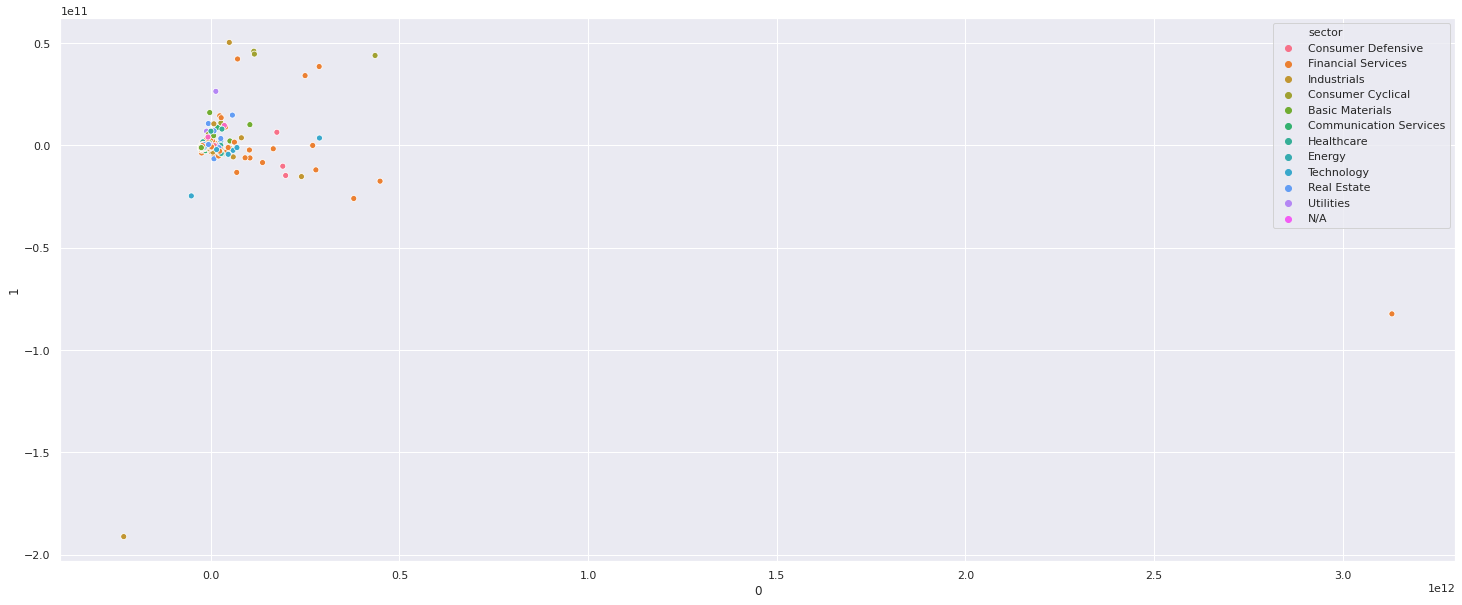

In [458]:
plt.figure(figsize=(25,10))
sns.scatterplot(x=0, y=1, data=X, hue="sector")

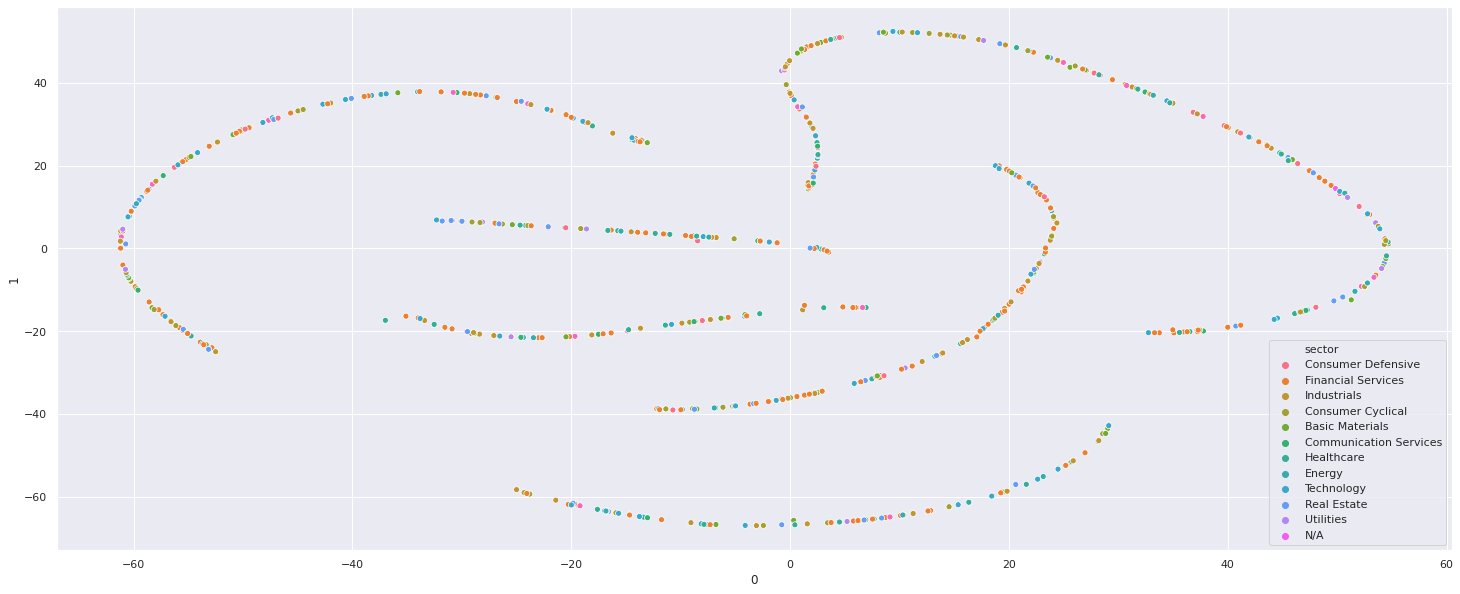

In [335]:
plt.figure(figsize=(25,10))
sns.scatterplot(x=0, y=1, data=X_embedded, hue="sector")

In [336]:
115 / 12673000000 / 17352119000 

5.229568886278029e-19

In [330]:
X_embedded.shape

(2465, 4)

In [215]:
X_embedded[X_embedded['peRatioTTM']>0].groupby('sector')['peRatioTTM'].mean().reset_index()

,sector,peRatioTTM
0,,2200.491473
1,Basic Materials,165.359694
2,Communication Services,198.810165
3,Consumer Cyclical,65.784018
4,Consumer Defensive,155.249855
5,Energy,29.090402
6,Financial Services,58.897028
7,Healthcare,67.837330
8,Industrials,88.930018
9,N/A,11.563834


In [222]:
X_embedded.sort_values('peRatioTTM', ascending=False)[:50]

,0,1,sector,peRatioTTM,symbol,tmp
5040,36.819630,15.125997,,67245.656322,CSWCL,0
5861,40.874454,14.698698,,41502.999289,NMFX,0
2068,2.451275,-37.598022,Technology,18113.569375,CEVA,0
3792,41.085438,6.943515,Communication Services,12151.424625,MDCA,0
6566,48.250954,-6.301737,Basic Materials,12055.541000,FCX,0
3867,-8.324629,-29.086733,Industrials,9247.269120,ADSW,0
1902,-29.842619,-34.475948,Consumer Defensive,8240.885000,POST,0
2604,60.349766,35.210758,Financial Services,4309.394149,SLQT,0
3042,-12.331738,-22.246773,Financial Services,2840.365819,HUIZ,0
5334,-21.446587,-55.052292,Consumer Cyclical,2553.191460,HGV,0


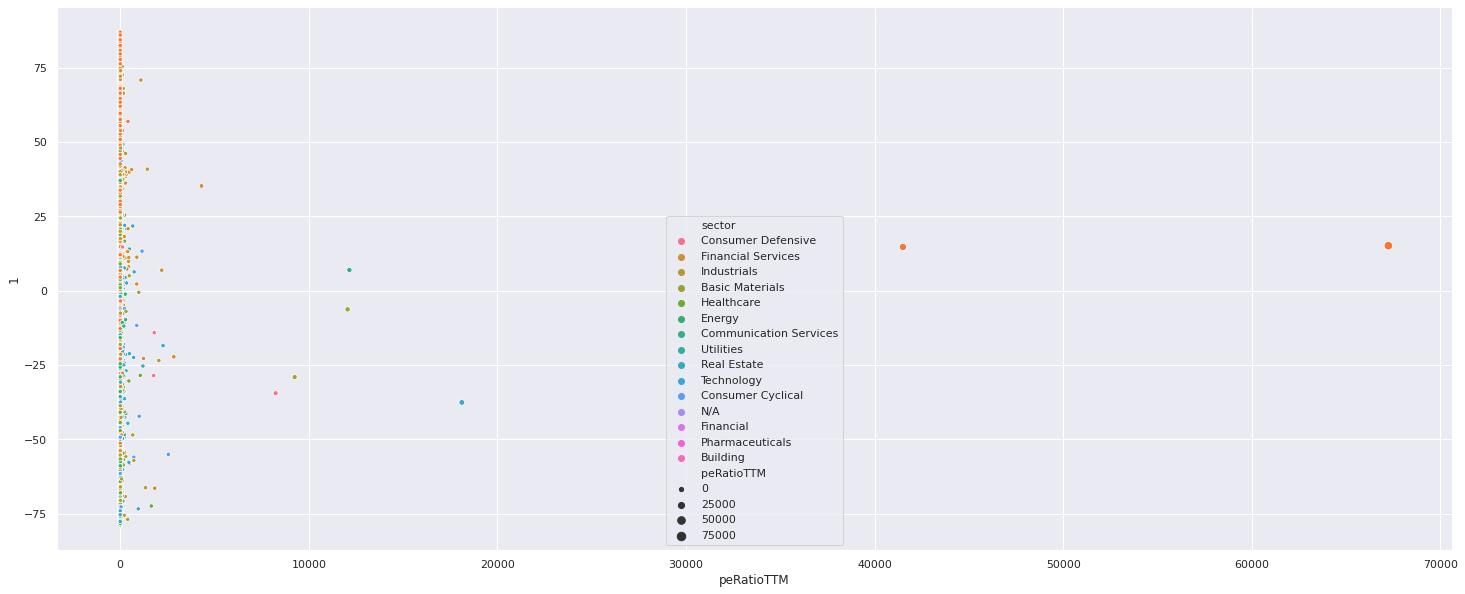

In [225]:
plt.figure(figsize=(25,10))
sns.scatterplot(x='peRatioTTM', y=1, size='peRatioTTM', data=X_embedded, hue="sector")

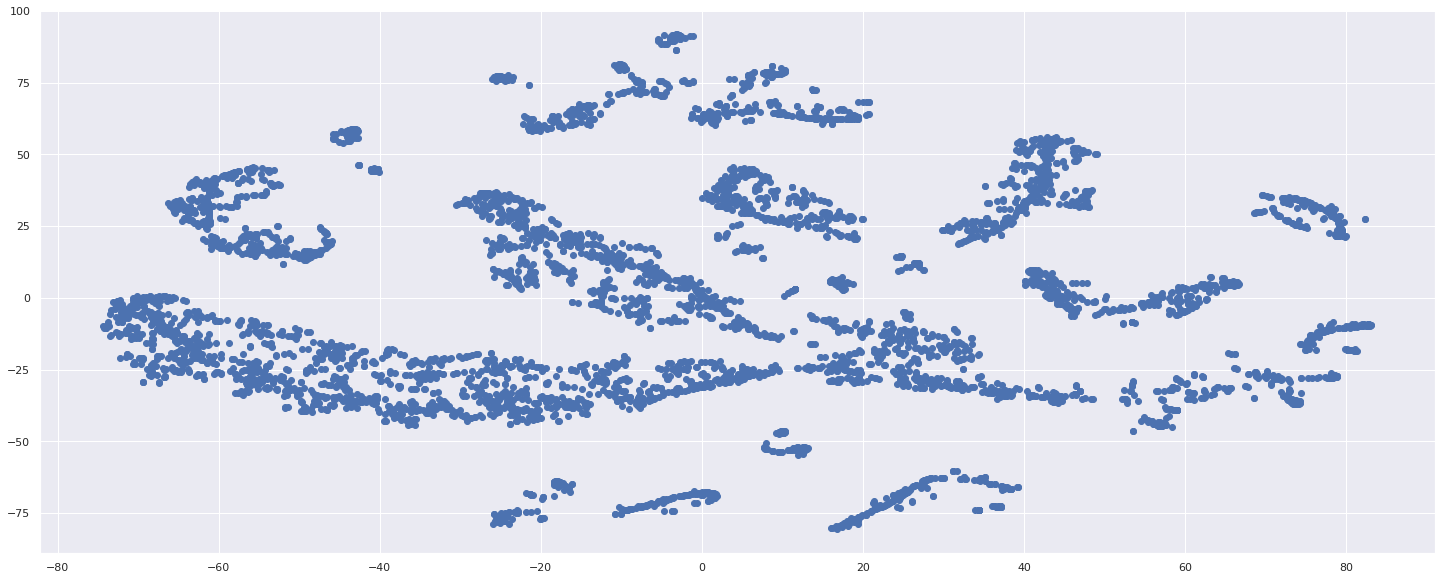

In [133]:
plt.figure(figsize=(25,10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

In [82]:
len(arr)

8881

In [99]:
df.columns

Index(['symbol', 'price', 'beta', 'volAvg', 'mktCap', 'lastDiv', 'range',
       'changes', 'companyName', 'currency', 'cik', 'isin', 'cusip',
       'exchange', 'exchangeShortName', 'industry', 'website', 'description',
       'ceo', 'sector', 'country', 'fullTimeEmployees', 'phone', 'address',
       'city', 'state', 'zip', 'dcfDiff', 'dcf', 'image', 'ipoDate',
       'defaultImage'],
      dtype='object')

In [25]:
df.sort_values('mktCap', ascending=False)[:20][['symbol', 'sector']]

,symbol,sector
7602,AAPL,Technology
451,MSFT,Technology
2052,AMZN,Consumer Cyclical
3541,GOOGL,Communication Services
26,GOOG,Communication Services
4374,FB,Communication Services
3396,BABA,Consumer Cyclical
7180,TSLA,Consumer Cyclical
4663,BRKA,Industrials
5967,BRKB,


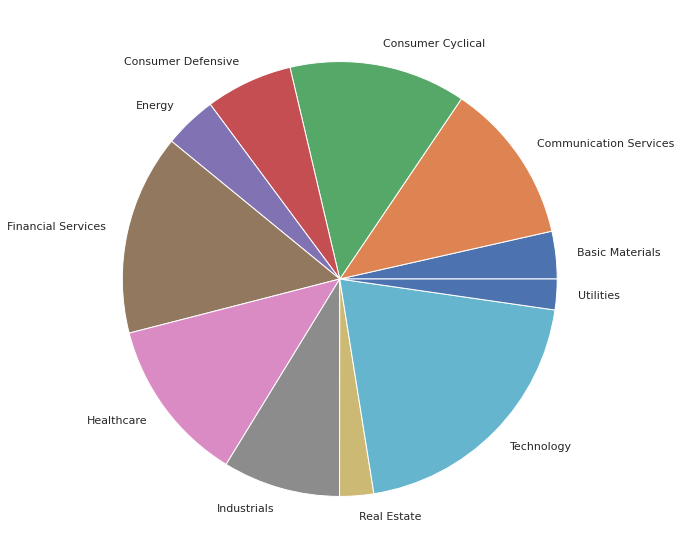

In [74]:
tmp = df.groupby('sector')['mktCap'].sum().reset_index()[1:]
tmp = tmp[tmp['mktCap'] / tmp['mktCap'].sum() > 0.01]
plt.figure(figsize=(25,10))
plt.pie(tmp['mktCap'], labels=tmp['sector'])
plt.show()

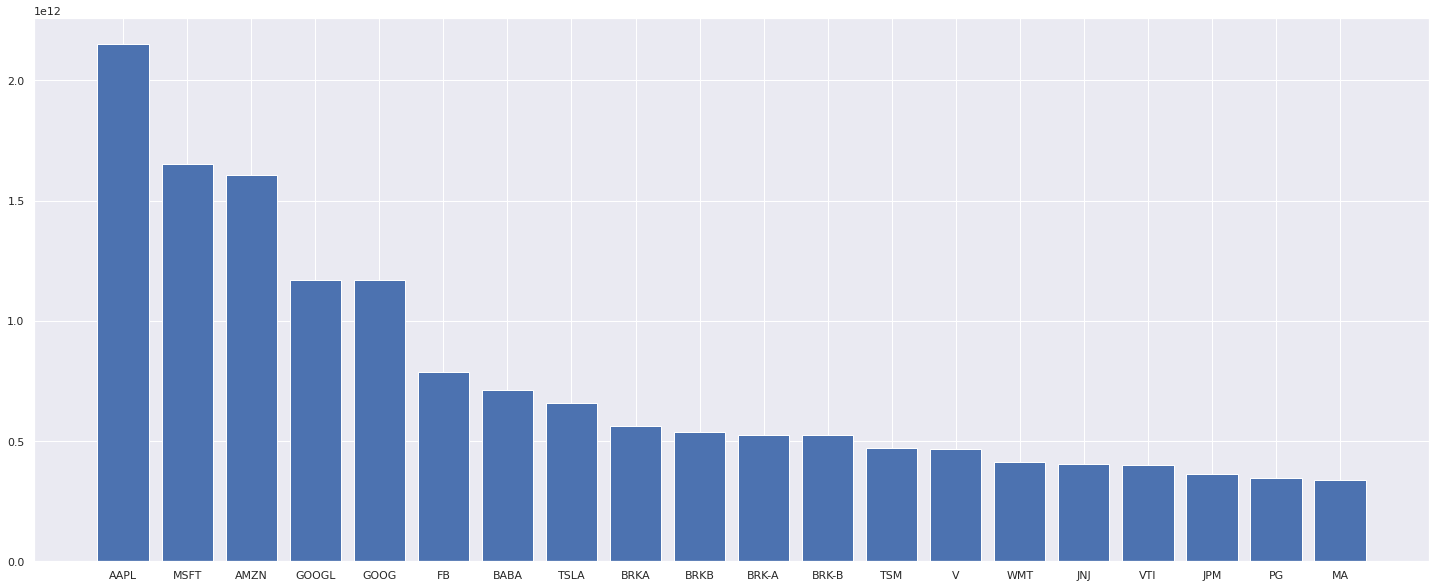

In [73]:
tmp = df.sort_values('mktCap', ascending=False)[:20]
plt.figure(figsize=(25,10))
plt.bar(tmp['symbol'], tmp['mktCap'])
plt.show()

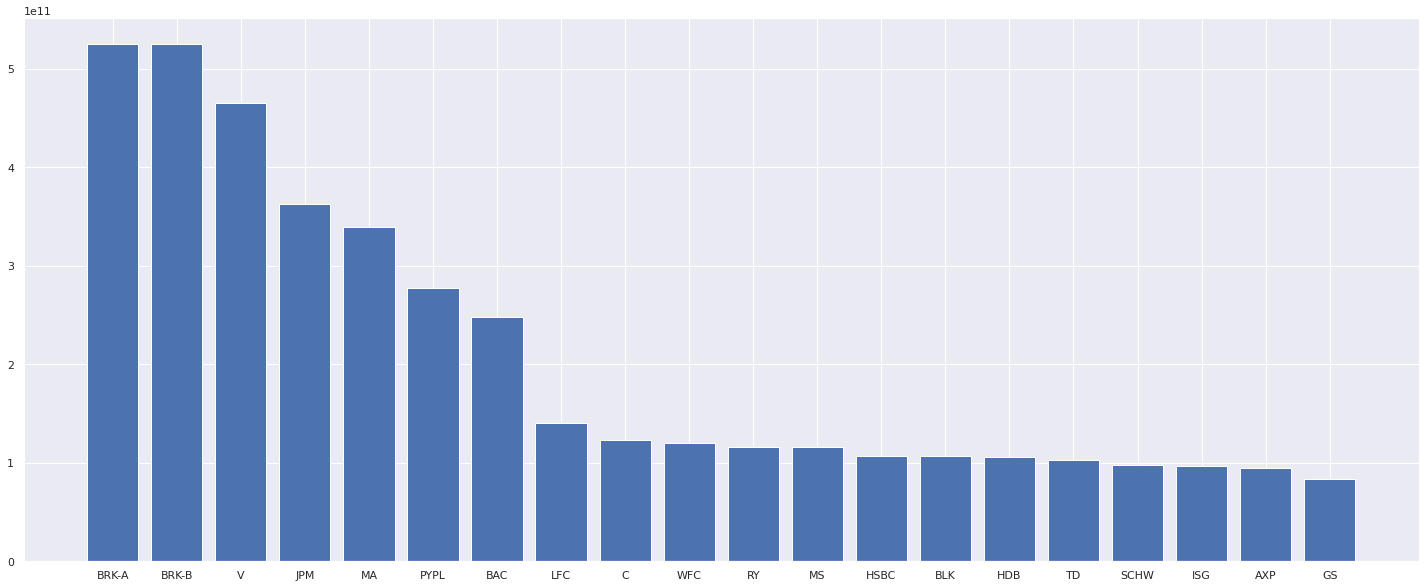

In [75]:
tmp = df[df['sector']=='Financial Services'].sort_values('mktCap', ascending=False)[:20]
plt.figure(figsize=(25,10))
plt.bar(tmp['symbol'], tmp['mktCap'])
plt.show()

In [28]:
tmp

,symbol,price,beta,volAvg,mktCap,lastDiv,range,changes,companyName,currency,...,phone,address,city,state,zip,dcfDiff,dcf,image,ipoDate,defaultImage
2052,AMZN,3201.65,1.287330,4681029.0,1.606431e+12,0.000000,1626.03-3552.25,-34.43,Amazon.com Inc,USD,...,12062661000,410 Terry Ave N,Seattle,WASHINGTON,98109-5210,-1002.74,3256.5500,https://financialmodelingprep.com/image-stock/...,1997-05-01,False
3396,BABA,260.00,1.297400,17821456.0,7.136298e+11,0.000000,169.95-319.32,-4.43,Alibaba Group Holding Ltd,CNY,...,8657185022088,"No.699 Wang Shang Road, Binjiang District",Hangzhou,ZHEJIANG,311121,1550.96,317.8120,https://financialmodelingprep.com/image-stock/...,2014-09-19,True
7180,TSLA,695.00,1.912110,48315939.0,6.587912e+11,0.000000,70.102-695.0,39.10,Tesla Inc,USD,...,16506815000,3500 Deer Creek Rd,Palo Alto,CALIFORNIA,94304,12772.30,458.0520,https://financialmodelingprep.com/image-stock/...,2010-06-29,False
6094,DIS,172.89,1.076990,11756478.0,3.130139e+11,0.880000,79.07-179.45,-0.66,Walt Disney Co,USD,...,18185601000,500 S Buena Vista St,Burbank,CALIFORNIA,None,27.69,129.8820,https://financialmodelingprep.com/image-stock/...,1957-11-12,True
764,HD,270.45,1.104020,3744479.0,2.911665e+11,6.000000,140.63-292.95,-3.52,Home Depot Inc,USD,...,17704338211,2455 Paces Ferry Rd SE,Atlanta,GEORGIA,30339,-40.16,286.4540,https://financialmodelingprep.com/image-stock/...,1984-04-19,False
415,NKE,137.28,0.808250,6544120.0,2.155063e+11,1.010000,60.0-141.14,-3.22,Nike Inc,USD,...,15036713173,1 SW Bowerman Dr,Beaverton,OREGON,97005,-8.59,134.6750,https://financialmodelingprep.com/image-stock/...,1990-10-17,True
1527,TM,153.77,0.901214,186692.0,2.149443e+11,2.225110,108.01-156.3,-0.87,Toyota Motor Corporation,USD,...,81 565 28 2121,1 Toyota-cho,Toyota,None,471-8571,NaN,0.0000,https://financialmodelingprep.com/image-stock/...,None,True
945,PDD,149.37,0.000000,8466915.0,1.831769e+11,0.000000,30.2-163.1,-0.58,Pinduoduo Inc,CNY,...,862152661300,,Shanghai,SHANGHAI,200051,NaN,90.2300,https://financialmodelingprep.com/image-stock/...,2018-07-26,True
6448,MCD,215.08,0.622450,3077164.0,1.602585e+11,5.040000,124.23-231.91,0.83,Mcdonald's Corp,USD,...,16306233000,110 N Carpenter St,Chicago,ILLINOIS,60607,NaN,229.3650,https://financialmodelingprep.com/image-stock/...,1966-07-05,True
5931,JD,81.53,1.361720,11973340.0,1.285418e+11,0.000000,32.7-92.77,-1.18,JD.com Inc.,USD,...,None,Building A,Beijing,None,101111,176.32,205.9900,https://financialmodelingprep.com/image-stock/...,None,True


In [22]:
df['sector'].unique()

array(['Consumer Defensive', 'Technology', '', 'Financial Services',
       'Basic Materials', 'Healthcare', 'Industrials', 'Real Estate',
       'Energy', 'Consumer Cyclical', 'Communication Services',
       'Utilities', None, 'N/A', 'Media', 'Industrial Goods', 'Financial',
       'Pharmaceuticals', 'Building'], dtype=object)